In [3]:
!pip install -q torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 34.2 MB/s eta 0:00:00


In [4]:
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T

dataset = Planetoid(root='data/Cora', name='Cora', transform=T.NormalizeFeatures())
data = dataset[0]
print(f'Dataset: {dataset}')
print(f'Nodes: {data.num_nodes}, Edges: {data.num_edges}')

Processing...


Dataset: Cora()
Nodes: 2708, Edges: 10556


Done!


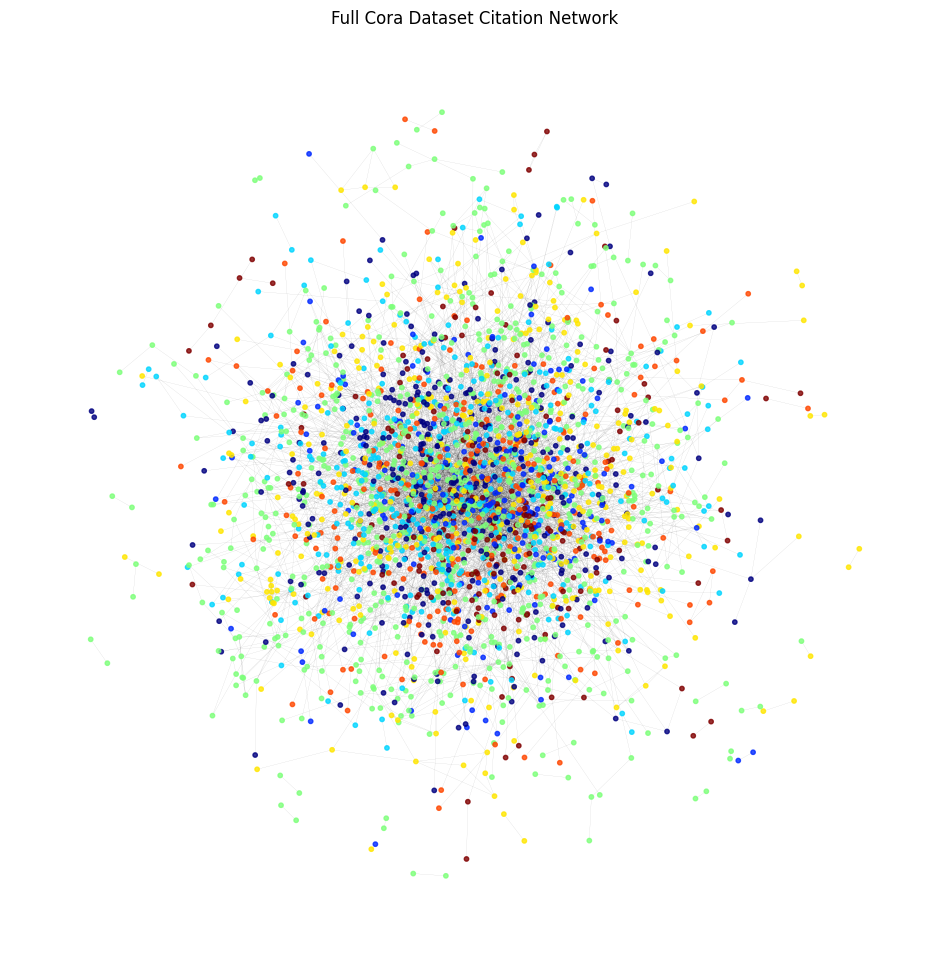

In [5]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)

plt.figure(figsize=(12, 12))
plt.title("Full Cora Dataset Citation Network")

pos = nx.spring_layout(G, k=0.15, iterations=20)

nx.draw_networkx_nodes(G, pos,
                       node_size=10,
                       node_color=data.y.numpy(),
                       cmap='jet',
                       alpha=0.8)

nx.draw_networkx_edges(G, pos, width=0.1, alpha=0.3)

plt.axis('off')
plt.show()

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [7]:
def renormalize_adj(adj):
  adj_tilde = adj + torch.eye(adj.shape[0]).to(adj.device)
  D = adj_tilde.sum(dim=1)
  D_inv_sqrt = D.pow(-0.5)
  D_inv_sqrt = torch.diag(D_inv_sqrt)
  return D_inv_sqrt @ adj_tilde @ D_inv_sqrt

In [8]:
class GCNLayer(nn.Module):
  def __init__(self, in_dim, out_dim):
    super().__init__()
    self.linear_layer = nn.Linear(in_dim, out_dim)

  def forward(self, adj_tilde,  embeddings):
    return self.linear_layer(adj_tilde @ embeddings)


In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [10]:
x = data.x.to(device)
y = data.y.to(device)

train_mask = data.train_mask.to(device)
val_mask = data.val_mask.to(device)
test_mask = data.test_mask.to(device)

In [11]:
from torch_geometric.utils import to_dense_adj
adj_dense = to_dense_adj(data.edge_index)[0].to(device)

In [12]:
adj_dense_norm =  renormalize_adj(adj_dense)

In [16]:
class PaperClassifier(nn.Module):
  def __init__(self, input_dim, embed_dim, num_classes=7, n_layers=2):
    super().__init__()
    self.gcn1 = GCNLayer(input_dim, embed_dim)
    self.act1 = nn.ReLU()
    self.gcn2 = GCNLayer(embed_dim, num_classes)
    self.dropout = nn.Dropout()
    self.act2 = nn.Softmax()
  def forward(self, x, adj_norm):
    embeddings = self.gcn1(adj_norm, x)
    embeddings = self.act1(embeddings)
    embeddings = self.dropout(embeddings)
    logits = self.gcn2(adj_norm, embeddings)
    return logits

In [39]:
model = PaperClassifier(x.shape[1], embed_dim=128).to(device)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

In [40]:
from tqdm import tqdm

train_losses = []
val_losses = []
val_accs = []
NUM_EPOCHS = 1000
loop = tqdm(range(NUM_EPOCHS))

for epoch in loop:
    model.train()
    optimizer.zero_grad()

    logits = model(x, adj_dense_norm)

    loss = criterion(logits[train_mask], y[train_mask])

    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        val_logits = model(x, adj_dense_norm)

        v_loss = criterion(val_logits[val_mask], y[data.val_mask])
        val_losses.append(v_loss.item())
        val_preds = val_logits[data.val_mask].argmax(dim=1)
        val_acc = (val_preds == y[val_mask]).float().mean()
        val_accs.append(val_acc.item())
    loop.set_description(f'Epoch: {epoch+1:03d}')
    loop.set_postfix(loss=f'{loss.item():.4f}', val_loss=f'{v_loss.item():.4f}', val_acc=f'{val_acc:.4f}')

Epoch: 1000: 100%|██████████| 1000/1000 [00:13<00:00, 73.61it/s, loss=0.0202, val_acc=0.7820, val_loss=0.7352]


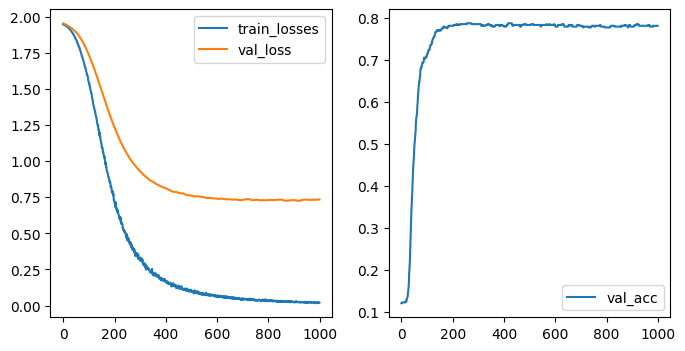

In [42]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
axes = axes.flatten()
axes[0].plot(train_losses, label='train_losses')
axes[0].plot(val_losses, label='val_loss')
axes[0].legend()
axes[1].plot(val_accs, label='val_acc')
axes[1].legend()
plt.show()

In [43]:
print(f"Max accuracy: {max(val_accs)}")
print(f"Min val loss: {min(val_losses)}")

Max accuracy: 0.7880000472068787
Min val loss: 0.7252295613288879
